In [253]:
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import pandas as pd
eps = np.finfo(float).eps
import operator
from tabulate import tabulate

In [254]:
def preprocess_data(path):
    data = pd.read_csv(path)
    data.drop(data.columns[[0]], axis = 1, inplace = True)
    return data

In [255]:
def input_output_split(data):
    input = data.iloc[:,0:7]
    input.insert(0,'ones',1)
    output = data.iloc[:,7]
    return input, output

In [256]:
def split_data(data):
#     train_data = dataset.sample(frac=0.8)
#     val_data = dataset.drop(train_data.index)
    train_data, val_data = np.split(data, [int(.8*len(data))])
    train_data = train_data.reset_index(drop = True)
    val_data = val_data.reset_index(drop = True)
    return train_data, val_data

In [257]:
def normalize(data):
    for i in data.columns[:-2]:
        data[i] = (data[i] - data[i].mean())/data[i].std()
    return data

In [258]:
def sigmoid_func(input):
    result = 1 / (1 + np.exp(-input))
    return result

In [259]:
def theta_gen(alpha, epochs, input, actual_output):
    theta = np.zeros(input.shape[1])
    for i in range(epochs):
        z = np.dot(input, theta)
        h = sigmoid_func(z)
        gradient = np.dot(input.T, (h - actual_output)) / actual_output.size
        theta -= alpha * gradient
    return theta

In [260]:
def logistic_predict(input, theta):
    temp = np.dot(input,theta)
    return sigmoid_func(temp)

In [261]:
def predict_with_threshold(input, threshold, theta):
    return logistic_predict(input, theta) >= threshold

In [262]:
def plot_graph(input1, input2, input3 = None):
    fig, ax = plt.subplots(figsize=(12,6))
    ax.plot(input1, input2, color="red", lw=1, ls='-');
    if(input3 != None):
        ax.plot(input1, input3, color="blue", lw=1, ls='-');
    plt.title("Threshold vs Accuracy Plot")
    plt.xlabel("Threshold")
    plt.ylabel("Accuracy (%)")
    plt.show()

In [263]:
def log_regression():
    alpha = 0.01
    epochs = 10000
    data = preprocess_data("../input/AdmissionDataset/data.csv")
    data = normalize(data)
    train_data, val_data = split_data(data)
    train_in, train_out = input_output_split(train_data)
    val_in, val_out = input_output_split(val_data)
    theta = theta_gen(alpha, epochs, train_in, train_out)
    
    accuracy  = []
    precision = []
    recall    = []
    threshold = []
    for t in range(1, 10):
        threshold.append(t / 10)
        
    correct = 0
    for t in threshold:
        correct = 0
        actual = (val_out >= t)
        predicted = predict_with_threshold(val_in, t, theta)
        
        actual_label_series = pd.Series(actual, name='Actual Output')
        prediction_label_series = pd.Series(predicted, name='Predicted Output')
        confusion_df = pd.crosstab(actual_label_series, prediction_label_series, margins=True)
        print(tabulate(confusion_df, headers='keys', tablefmt='psql'))
        
        labels = confusion_df.keys()[:-1]
        precision_dict = {}
        recall_dict    = {}
        f1_dict        = {}
        
        for label in labels:
            correct += confusion_df[label][label]
            temp_precision = float(confusion_df[label][label]) / confusion_df['All'][label]
            precision_dict[label] = round(temp_precision * 100, 2)
            temp_recall = float(confusion_df[label][label]) / confusion_df[label]['All']
            recall_dict[label] = round(temp_recall * 100, 2)

            if temp_recall == 0.0:
                temp_recall = eps
            if temp_precision == 0.0:
                temp_precision = eps

        acc = round((float(correct) / confusion_df['All']['All']) * 100, 2)
        accuracy.append(acc)
        precision.append(precision_dict[True])
        recall.append(recall_dict[True])

    return threshold, accuracy, precision, recall

# <font color = "blue">PART 1 : Implement Logistic Regression Model</font>

In [265]:
threshold, accuracy, precision, recall = log_regression()

+-----------------+--------+-------+
| Actual Output   |   True |   All |
|-----------------+--------+-------|
| True            |     90 |    90 |
| All             |     90 |    90 |
+-----------------+--------+-------+
+-----------------+--------+-------+
| Actual Output   |   True |   All |
|-----------------+--------+-------|
| True            |     90 |    90 |
| All             |     90 |    90 |
+-----------------+--------+-------+
+-----------------+--------+-------+
| Actual Output   |   True |   All |
|-----------------+--------+-------|
| True            |     90 |    90 |
| All             |     90 |    90 |
+-----------------+--------+-------+
+-----------------+---------+--------+-------+
| Actual Output   |   False |   True |   All |
|-----------------+---------+--------+-------|
| False           |       0 |      1 |     1 |
| True            |       1 |     88 |    89 |
| All             |       1 |     89 |    90 |
+-----------------+---------+--------+-------+
+----

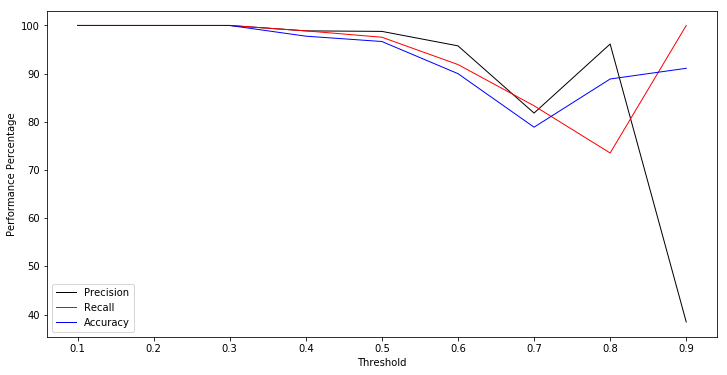

In [266]:
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(threshold, precision, color="black", lw=1, ls='-',label = 'Precision');
ax.plot(threshold, recall, color="red", lw=1, ls='-',label = 'Recall');
ax.plot(threshold, accuracy, color="blue", lw=1, ls='-',label = 'Accuracy');
plt.xlabel("Threshold")
plt.ylabel("Performance Percentage")
plt.legend()
plt.show()

# <font color = "blue">PART 2 : comparison of KNN and Logistic Regression</font>

In [237]:
def euclid_distance(p1, p2):
    distance = 0.0
    length = len(p1) - 1
#     print(length)
    for i in range(1, length):
        distance += (np.square(p1[i] - p2[i]))
    return np.sqrt(distance)

In [238]:
def find_winner(k_list):
    temp = []
    zeroes = 0
    ones = 0
    for it in k_list:
        temp.append(it[1])
        if it[1] == False:
            zeroes+=1
        else:
            ones+=1
    if zeroes > ones:
        return False
    else:
        return True

In [239]:
def build_KNN(k,train,validate):
    k_list = []
    TP = 0
    FP = 0
    TN = 0
    FN = 0
    index = 0
    predicted = []
    actual = []
    itr = 0
    for index_validate, row_validate in validate.iterrows():
        distance_list = []
        for index_train, row_train in train.iterrows():
            itr += 1
            distance_list.append((euclid_distance(row_validate,row_train), row_train[-1]))
       
        distance_list = sorted(distance_list, key = operator.itemgetter(0))
        k_list = distance_list[0:k]
        predicted_value = find_winner(k_list)
        predicted.append(predicted_value)
        actual_value = row_validate[-1]
        actual.append(actual_value)
        
        if (predicted_value == False and actual_value == False):
            TN += 1
        elif (predicted_value == True and actual_value == False):
            FP += 1
        elif (predicted_value == True and actual_value == True):
            TP += 1
        else:
            FN += 1
    return TP, FP, TN, FN, predicted, actual

In [240]:
def validate_KNN(k, train, validate):
    TP, FP, TN, FN, predicted_list, actual_list = build_KNN(k, train, validate)
    accuracy = ((TP + TN)/(TP + TN + FP + FN)) * 100
    positive = TP + FP
    precision = (TP / positive)
    actual_positive = TP + FN
    recall = TP / actual_positive
    recall_inv = 1/recall
    precision_inv = 1/precision
    den = recall_inv + precision_inv
    f1_score = (2 / den)
#     print("accuracy = ",accuracy," precision = ", precision*100 , " recall = ",recall*100 , " f1_score = ", f1_score*100)
    return(accuracy)

In [241]:
def find_max_accuracy_and_k(train, validate):
    accuracy_list = []
    x_list = []
    max_k = 0
    max_accuracy = 0
    for k in range(1,12,2):
        accuracy = validate_KNN(k, train, validate)
        accuracy_list.append(accuracy)
        x_list.append(k)
        if(accuracy > max_accuracy):
            max_accuracy = accuracy
            max_k = k
    return max_accuracy

In [242]:
def prepare_data(threshold, data):
    data_knn = data.iloc[:, :-1]
    Y_knn = data.iloc[:,-1] >= threshold
    data_knn["Chance of Admit"] = Y_knn

    train, validate = np.split(data_knn,[int(.8*len(data_knn))])
    train = train.reset_index(drop = True)
    validate = validate.reset_index(drop = True)

    return train,validate

In [243]:
def KNN():
    data = preprocess_data("../input/AdmissionDataset/data.csv")
    data = normalize(data)
    threshold = []
    for t in range(1, 10):
        threshold.append(t/10)
        
    knn_accuracy = []
    for t in threshold:
        train, validate = prepare_data(t, data)
        max_accuracy = find_max_accuracy_and_k(train, validate)
        knn_accuracy.append(max_accuracy)
    return threshold, knn_accuracy

In [244]:
threshold, knn_accuracy = KNN()

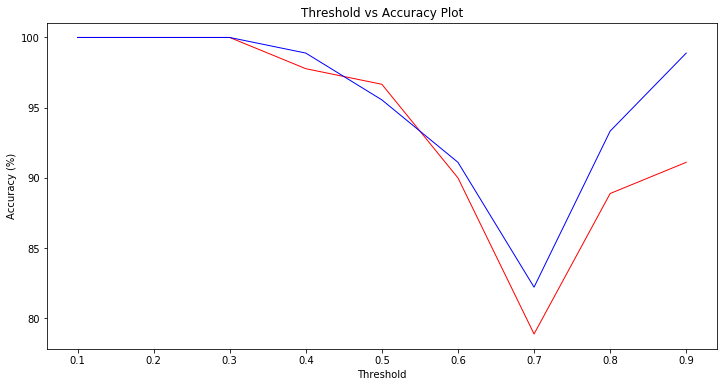

In [245]:
plot_graph(threshold, accuracy, knn_accuracy)

# PART 3 :

## Report the criteria one should use while deciding the threshold value. Explain the reason behind your choice of threshold in your model.

The main visualization technique for showing the performance of a classification model is the Receiver Operating Characteristic (ROC) curve. 
* The ROC curve shows how the recall vs precision relationship changes as we vary the threshold for identifying a positive in our model. The threshold represents the value above which a data point is considered in the positive class. If we have a model for identifying a disease, our model might output a score for each patient between 0 and 1 and we can set a threshold in this range for labeling a patient as having the disease (a positive label). By altering the threshold, we can try to achieve the right precision vs recall balance.

* An ROC curve plots the true positive rate on the y-axis versus the false positive rate on the x-axis. The true positive rate (TPR) is the recall and the false positive rate (FPR) is the probability of a false alarm. Both of these an be calculated from the confusion matrix.
* I chose threshold as 0.5 as it is visible from the graph that at 0.5 the precision, accuracy, recall values are almost close to each other and there is very little variation.